goal:

- use librosa on 1000 audio files and/or 50 class folders minimum
- store information in a dataframe (excluding actual file data for now)
  - folder name, file name, sampling rate, data length, file length, file size(?)

In [6]:
import pandas as pd
import numpy as np
import random
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchaudio
import copy
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

from tqdm import tqdm
from IPython.display import Audio

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import RandomOverSampler

from math import floor

import sys

In [7]:
def reset_seed():
    torch.manual_seed(1368)
    random.seed(1368)
    np.random.seed(1368)

reset_seed()

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for i in range(torch.cuda.device_count()):
   print(torch.cuda.get_device_properties(i).total_memory)

print(device)
print(torch.cuda.get_device_name())

8546353152
cuda
NVIDIA GeForce RTX 5060


In [9]:
def get_random_folders_filtered(base_dir: str, split_interval_secs: float, sample_rate: int = 32000, total_folders: int = 50, max_files_per_folder: int = 100, min_rating: float = 4.0):
    # base_dir: directory of all the audio file folders
    # split_interval_secs: the length of each sound clip when split up in a file.
    #   - final dataframe will not contain any sound clips over/under this length
    # sample_rate: sample rate of sound clips in hz
    # total_folders: total folders to iterate through the files, given range of files per folder
    # min_files_per_folder: minimum files to exist in the folder
    # max_files_per_folder: maximum files to use inside the folder
    
    folder_dict = {}

    folders = os.listdir(base_dir)
    folder_count = 0
    random.shuffle(folders)

    # get the list of valid folders and files to analyse
    folders = set()
    lines = set([l.replace("\n", "") for l in open(f"rating_thresholds_at_least_10_classes/min_rating_{int(min_rating * 2)}.txt").readlines()])
    for l in lines: folders.add(l.split("/")[0])

    folders = list(folders)
    folder_count = 0
    random.shuffle(folders)

    # if there are less folders than those specified, view all folders instead of given amount
    total_folders = min(len(folders), total_folders)

    rows = []
    
    for folder in folders:
        folder_path = base_dir + folder + "/"
        valid_folder_files = []
        # only iterate through the valid audio files
        for file in os.listdir(folder_path):
            if folder + "/" + file in lines:
                valid_folder_files.append(folder_path + file)
#        print(valid_folder_files)
        random.shuffle(valid_folder_files)
        valid_folder_files = valid_folder_files[:min(max_files_per_folder, len(valid_folder_files))]

        # iterate through each file in the folder
        for file_path in (progress_bar := tqdm(valid_folder_files)):
            # load file data and resample to sample_rate if necessary
            file_data, file_sample_rate_hz = torchaudio.load(uri=file_path, channels_first=True)
            if file_sample_rate_hz != sample_rate:
                file_data = torchaudio.functional.resample(file_data, orig_freq=file_sample_rate_hz, new_freq=sample_rate)

            # convert all audio into mono (1 channel) if audio is stereo (2 channels)
            if file_data.shape[0] == 2:
                file_data = file_data.mean(dim=0)
            else:
                file_data = file_data.flatten()

            # get total number of X second splits
            total_splits = floor(len(file_data) / (sample_rate * split_interval_secs))
            
            # convert file data into mel-spectrogram fourier transform for feeding into CNN
            mel_spec_transform = torchaudio.transforms.MelSpectrogram(sample_rate = sample_rate, power=2, n_fft=1024)
            amp_to_db_transform = torchaudio.transforms.AmplitudeToDB(stype="amplitude", top_db=80)
            mel_spec_data_db = amp_to_db_transform(mel_spec_transform(file_data))

            # if file is at least X seconds.
            if total_splits >= 1:
                folder_dict[folder] = folder_count

                # get split_size in hz (sample rate * split_interval_secs)
                split_indices = np.arange(0, len(file_data), int(split_interval_secs * sample_rate))  // (1024 // 2)

                # split the file data and add each split to the dataframe
                for i in range(len(split_indices) - 1):
                    start = split_indices[i]
                    end = split_indices[i + 1]

                    mel_spec_split_data = mel_spec_data_db[:, start:end]

                    row = {}
                    row["folder_class"] = folder_dict[folder]
                    row["folder"] = folder
                    row["file"] = file_path.split("/")[-1]
                    row["mel_spec_data"] = mel_spec_split_data
                    row["mel_spec_shape"] = mel_spec_split_data.shape

                    rows.append(row)

            progress_bar.set_description(f"Folder {folder_count + 1}/{total_folders} - {folder}")

        # end loop if total_folders has been reached
        folder_count += 1
        if folder_count >= total_folders: break

    return pd.DataFrame(rows)

In [10]:
# base_dir = "/mnt/lustre/peprmint/train_audio/"
base_dir = "../datasets/birdsongs-combined/train_audio/"

split_interval_secs = 1
sample_rate = 32000

reset_seed()

folder_df = get_random_folders_filtered(
    base_dir,
    split_interval_secs=split_interval_secs,
    sample_rate=sample_rate,
    total_folders=5,
    max_files_per_folder=50,
    min_rating=4.0
)

Folder 1/5 - bkbmag1:   0%|          | 0/27 [00:00<?, ?it/s]

Folder 5/5 - hoowar: 100%|██████████| 50/50 [00:04<00:00, 11.29it/s]


In [11]:
folder_df["file"].value_counts()

file
XC424610.mp3    332
XC424789.ogg    203
XC153179.ogg    195
XC366686.ogg    185
XC137960.mp3    166
               ... 
XC601810.ogg      2
XC372592.mp3      2
XC362925.ogg      2
XC179934.ogg      2
XC522770.ogg      1
Name: count, Length: 165, dtype: int64

In [12]:
folder_df["mel_spec_data"].values[0].shape

torch.Size([128, 62])

In [13]:
for name, value in list(locals().items()):
    print(name, round(sys.getsizeof(value) / 1024 ** 2, 2), "MB")

__name__ 0.0 MB
__doc__ 0.0 MB
__package__ 0.0 MB
__loader__ 0.0 MB
__spec__ 0.0 MB
__builtin__ 0.0 MB
__builtins__ 0.0 MB
_ih 0.0 MB
_oh 0.0 MB
_dh 0.0 MB
In 0.0 MB
Out 0.0 MB
get_ipython 0.0 MB
exit 0.0 MB
quit 0.0 MB
open 0.0 MB
_ 0.0 MB
__ 0.01 MB
___ 0.0 MB
__vsc_ipynb_file__ 0.0 MB
_i 0.0 MB
_ii 0.0 MB
_iii 0.0 MB
_i1 0.0 MB
pd 0.0 MB
np 0.0 MB
random 0.0 MB
os 0.0 MB
plt 0.0 MB
torch 0.0 MB
nn 0.0 MB
F 0.0 MB
torchvision 0.0 MB
torchaudio 0.0 MB
copy 0.0 MB
warnings 0.0 MB
tqdm 0.0 MB
Audio 0.0 MB
LabelEncoder 0.0 MB
train_test_split 0.0 MB
RandomOverSampler 0.0 MB
floor 0.0 MB
sys 0.0 MB
_i2 0.0 MB
reset_seed 0.0 MB
_i3 0.0 MB
device 0.0 MB
i 0.0 MB
_i4 0.0 MB
get_random_folders_torchaudio 0.0 MB
_i5 0.0 MB
base_dir 0.0 MB
split_interval_secs 0.0 MB
sample_rate 0.0 MB
folder_df 2.02 MB
_i6 0.0 MB
_i7 0.0 MB
_i8 0.0 MB
_i9 0.0 MB
get_random_folders_filtered 0.0 MB
_i10 0.0 MB
_i11 0.0 MB
_11 0.01 MB
_i12 0.0 MB
_12 0.0 MB
_i13 0.0 MB


In [14]:
print("sound clips BEFORE any sampling:", len(folder_df))

sound clips BEFORE any sampling: 7438


In [15]:
len(folder_df["folder"].unique())

5

<Axes: title={'center': 'Value counts before over/under sampling.'}, xlabel='folder'>

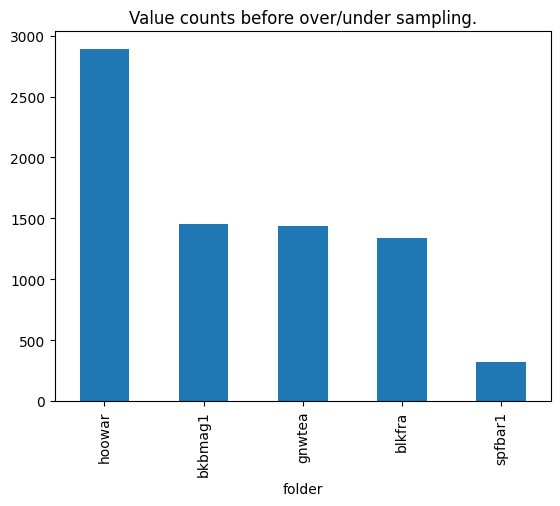

In [16]:
folder_df["folder"].value_counts().plot.bar(title="Value counts before over/under sampling.")

In [17]:
# apply random undersampling OR oversampling

sampling_technique = "median"

reset_seed()

if sampling_technique == "under":
    # random "naive" undersampling
    # delete random rows from all classes except minority class(es)
    min_folder_count = min(folder_df["folder"].value_counts())

    indices_to_keep = np.array([])

    for f in folder_df["folder"].unique():
        indices_to_keep = np.concat([np.random.choice(folder_df[folder_df["folder"] == f].index, size=min_folder_count), indices_to_keep])

    folder_df = folder_df.loc[indices_to_keep]
    folder_df.reset_index(drop=True, inplace=True)

if sampling_technique == "over":
    ros = RandomOverSampler(random_state=1368)

    # print how much each class will increase by (relative to its current size)
    max_folder = max(folder_df["folder"].value_counts())
    for folder, count in folder_df["folder"].value_counts().sort_values(ascending=True).items():
        print(f"{folder} will increase by {round((max_folder / count - 1) * 100, 2)}%")

    folder_df = pd.concat(ros.fit_resample(folder_df.drop("folder", axis=1), folder_df["folder"]), axis=1)
    # moves "folder" to other side of df but shouldn't affect anything

if sampling_technique == "median":
    # take the median value of folder counts
    # under sample all above the median
    # over smaple all below the median

    ros = RandomOverSampler(random_state=1368)
    median_folder_count = round(folder_df["folder"].value_counts().median())
    indices_to_keep = np.array([])

    print("median:", median_folder_count)

    for f in folder_df["folder"].unique():
        folder_length = len(folder_df[folder_df["folder"] == f])
        if folder_length > median_folder_count:
            indices_to_keep = np.concat([np.random.choice(folder_df[folder_df["folder"] == f].index, size=median_folder_count), indices_to_keep])
        else:
            indices_to_keep = np.concat([folder_df[folder_df["folder"] == f].index, indices_to_keep])
        
    folder_df = folder_df.loc[indices_to_keep]
    folder_df.reset_index(drop=True, inplace=True)
    
    folder_df = pd.concat(ros.fit_resample(folder_df.drop("folder", axis=1), folder_df["folder"]), axis=1)

median: 1433


<Axes: title={'center': 'Value counts after median sampling.'}, xlabel='folder'>

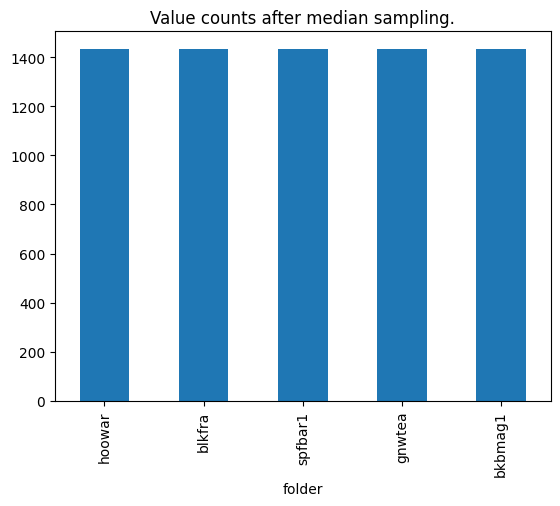

In [18]:
folder_df["folder"].value_counts().plot.bar(title=f"Value counts after {sampling_technique} sampling.")

In [19]:
print("sound clips AFTER sampling:", len(folder_df))

sound clips AFTER sampling: 7165


torch.Size([128, 63])


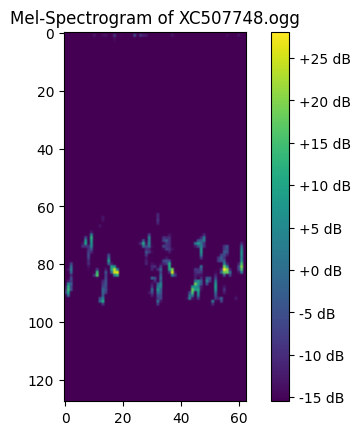

torch.Size([128, 63])


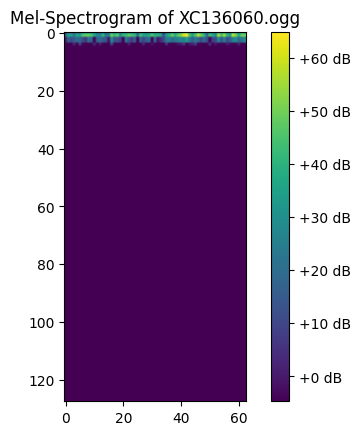

torch.Size([128, 63])


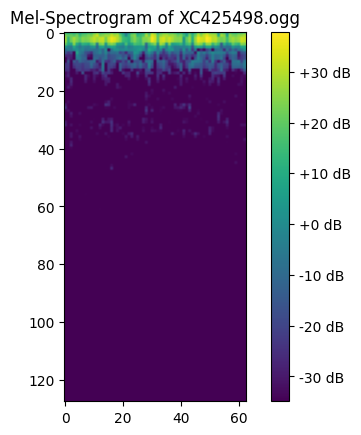

In [20]:
# plot 3 random mel spectrograms
# checks for consistency in scaling and whatnot

reset_seed()

sample_spec_indices = random.sample(folder_df.index.tolist(), k=3)

for i in sample_spec_indices:
    row = folder_df.iloc[i]
    
    print(row["mel_spec_shape"])
    
    plt.figure()
    plt.imshow(row["mel_spec_data"])
    plt.title(f"Mel-Spectrogram of {'/'.join(row['file'].split('/')[-2:])}")
    plt.colorbar(format='%+2.0f dB')
    plt.show()

del row

In [21]:
'''

# input shape needs to be AxBxCxD
# A = list of files
# B = depth of each one (currently just 1, as it only contains 1 value. if colours are used then maybe up it to 3)
# CxD = input width/height (128x626 etc)

x = torch.from_numpy(np.stack(folder_df["mel_spec_data"].values))
x = x.reshape(x.shape[0], 1, x.shape[1], x.shape[2])
x = x.to(device)

y = torch.LongTensor(folder_df["folder_class"])
y = y.to(device)

'''

'\n\n# input shape needs to be AxBxCxD\n# A = list of files\n# B = depth of each one (currently just 1, as it only contains 1 value. if colours are used then maybe up it to 3)\n# CxD = input width/height (128x626 etc)\n\nx = torch.from_numpy(np.stack(folder_df["mel_spec_data"].values))\nx = x.reshape(x.shape[0], 1, x.shape[1], x.shape[2])\nx = x.to(device)\n\ny = torch.LongTensor(folder_df["folder_class"])\ny = y.to(device)\n\n'

In [25]:
folder_df[folder_df["mel_spec_shape"] == (128, 62)]

,folder_class,file,mel_spec_data,mel_spec_shape,folder,test
1,4,XC366706.mp3,"[[tensor(-18.2070), tensor(-18.2070), tensor(-...","(128, 62)",hoowar,False
6,4,XC424610.mp3,"[[tensor(7.3460), tensor(7.3460), tensor(7.346...","(128, 62)",hoowar,False
7,4,XC147705.mp3,"[[tensor(-10.3073), tensor(18.3331), tensor(25...","(128, 62)",hoowar,False
10,4,XC113414.mp3,"[[tensor(10.9622), tensor(10.9622), tensor(10....","(128, 62)",hoowar,False
12,4,XC137960.mp3,"[[tensor(8.3429), tensor(8.3429), tensor(8.342...","(128, 62)",hoowar,True
...,...,...,...,...,...,...
7159,2,XC607574.ogg,"[[tensor(-8.3808), tensor(-8.3808), tensor(-8....","(128, 62)",spfbar1,False
7160,2,XC366686.ogg,"[[tensor(-22.8852), tensor(-22.8852), tensor(-...","(128, 62)",spfbar1,True
7162,2,XC366686.ogg,"[[tensor(-22.8852), tensor(-22.8852), tensor(-...","(128, 62)",spfbar1,True
7163,2,XC366686.ogg,"[[tensor(-22.8852), tensor(-22.8852), tensor(-...","(128, 62)",spfbar1,False


In [22]:
reset_seed()

# x_train, x_test, y_train, y_test = train_test_split(x, y, shuffle=True, test_size=0.2, random_state=1368)
# for sequential aggregation: train_test_split cannot be used, as the results need to be stored for testing data when evaluating model.
# workaround: 
folder_df["test"] = [True if random.uniform(0, 1) < 0.2  else False for _ in range(len(folder_df))]
train_df = folder_df[folder_df["test"] == False]
test_df = folder_df[folder_df["test"] == True]

x_train = torch.from_numpy(np.stack(train_df["mel_spec_data"].values)).to(device)
x_test = torch.from_numpy(np.stack(test_df["mel_spec_data"].values)).to(device)
y_train = torch.LongTensor(train_df["folder_class"].values).to(device)
y_test = torch.LongTensor(test_df["folder_class"].values).to(device)

x_train = x_train.reshape(x_train.shape[0], 1, x_train.shape[1], x_train.shape[2])
x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1], x_test.shape[2])

del train_df, test_df

ValueError: all input arrays must have the same shape

In [ ]:
# create machine learning model.

class TestModel(nn.Module):
    global folder_df

    def __init__(self, input_shape: torch.Size, dropout_rate: float = 0):
        super().__init__()

        total_output_classes = len(folder_df["folder"].unique())

        # input shape should be some list/tuple of length 4
        if len(input_shape) != 4: return Exception("Input shape is not AxBxCxD.")

        # define layers here
        # assuming input shape = 1x1x128x126 = AxBxCxD

        # conv2d: 1x128x126 -> 1x124x124 (kernel size = (5,3))
        # relu
        # max pool: 1x124x124 -> 1x62x62 (pool size = (2,2))
        # conv2d: 1x62x62 -> 1x60x60 (kernel size = (3, 3))
        # relu
        # max pool: 1x60x60 -> 1x30x30 (pool size = (2, 2))
        # flatten: 1x30x30 -> 900
        # linear: 900 -> 128
        # linear: 128 -> 32
        # linear: 32 -> (output layers)

        A = input_shape[0]
        B = input_shape[1]
        C = input_shape[2]
        D = input_shape[3]

        self.conv1 = nn.Conv2d(in_channels=B, out_channels=1, kernel_size=(5, 3)) # output shape = Ax1x(C-4)x(D-2)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2) # output shape = Ax1x(C-4 // 2)x(D-2 // 2)
        self.drop1 = nn.Dropout(p=dropout_rate)
        self.conv2 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(3, 3)) # output shape = Ax1x(C - 4 // 2 - 2)x(D - 2 // 2 - 2)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2) # output shape = Ax1x([(C - 4) // 2 - 2] // 2)x([(D - 2) // 2] - 2] // 2) idk the bracket order
        self.drop2 = nn.Dropout(p=dropout_rate)
        self.flat = nn.Flatten()

        flatten_nodes = ((((C - 4) // 2) - 2) // 2) * ((((D - 2) // 2) - 2) // 2)
        
        self.linear1 = nn.Linear(in_features=flatten_nodes, out_features=128)
        self.linear2 = nn.Linear(in_features=128, out_features=32) 
        self.output = nn.Linear(in_features=32, out_features=total_output_classes)

    def forward(self, x):
        # define calculations here
        x = self.relu1(self.conv1(x))
        x = self.pool1(x)
        x = self.drop1(x)
        x = self.relu2(self.conv2(x))
        x = self.pool2(x)
        x = self.drop2(x)
        x = self.flat(x)
        x = self.linear1(x)
        x = self.linear2(x)
        x = self.output(x)

        return x

In [ ]:
def train_model(model, loss_fn, optimizer, epochs, batch_size, save_best_to_file = False):
    batch_indices = np.linspace(0, len(x_train), int(len(x_train) / batch_size), dtype="int")

    train_loss_hist = []
    train_acc_hist = []
    test_acc_hist = []

    best_test_acc = 0
    best_model = None

    for epoch in range(1, epochs + 1):
        model.train()

        train_acc = 0
        
        for i in range(len(batch_indices) - 1):
            start_index = batch_indices[i]
            stop_index = batch_indices[i + 1]

            x_batch = x_train[start_index:stop_index]
            y_batch = y_train[start_index:stop_index]

            y_pred = model(x_batch)
            loss = loss_fn(y_pred, y_batch)
            train_acc += sum(torch.argmax(y_pred, dim=1) == y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_acc = train_acc * 100 / len(y_train)

        model.eval()
        test_acc = sum(torch.argmax(model(x_test), dim=1) == y_test) * 100 / len(y_test)

        print(f"Epoch {epoch}: train loss = {loss:.04f}, train acc = {train_acc:.02f}%, test acc = {test_acc:.02f}% {"!!" if test_acc > best_test_acc else ""}")

        train_loss_hist.append(float(loss.cpu().detach().numpy()))
        train_acc_hist.append(float(train_acc.cpu().detach().numpy()))
        test_acc_hist.append(float(test_acc.cpu().detach().numpy()))

        if test_acc > best_test_acc:
            best_test_acc = test_acc
            
            # overwrite best model with new best model
            best_model = copy.deepcopy(model.state_dict())

    best_model_path = ""

    if save_best_to_file:
        model_save_path = "models/"

        if not os.path.exists(model_save_path): os.mkdir(model_save_path)

        file_number = len(os.listdir(model_save_path)) + 1

        file_name = f"best_model_{file_number:>03}"

        best_model_path = model_save_path + file_name + ".pth"

        torch.save(best_model, best_model_path)
        

    plt.figure(figsize=(12,8))
    pd.Series(train_acc_hist).plot.line(label="Train", color="blue")
    pd.Series(test_acc_hist).plot.line(label="Test", color="red")
    plt.legend()
    plt.ylim((0, 100))
    plt.yticks(np.arange(0, 101, 10))
    plt.title(f"Convolutional Neural Network on {len(folder_df)} sound clips over {len(folder_df["folder"].unique())} folders.")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.grid(axis="y")
    plt.show()

    return train_loss_hist, train_acc_hist, test_acc_hist, best_model

Epoch 1: train loss = 2.8073, train acc = 36.50%, test acc = 13.79% !!
Epoch 2: train loss = 2.9484, train acc = 28.69%, test acc = 17.58% !!
Epoch 3: train loss = 2.9421, train acc = 32.61%, test acc = 17.53% 
Epoch 4: train loss = 2.7175, train acc = 29.94%, test acc = 17.07% 
Epoch 5: train loss = 2.8578, train acc = 35.03%, test acc = 14.99% 
Epoch 6: train loss = 2.8601, train acc = 28.09%, test acc = 15.48% 
Epoch 7: train loss = 2.7132, train acc = 21.04%, test acc = 21.33% !!
Epoch 8: train loss = 3.2017, train acc = 22.13%, test acc = 16.31% 
Epoch 9: train loss = 2.5682, train acc = 20.28%, test acc = 22.02% !!
Epoch 10: train loss = 2.6555, train acc = 22.90%, test acc = 19.25% 
Epoch 11: train loss = 2.4779, train acc = 24.22%, test acc = 20.39% 
Epoch 12: train loss = 2.4938, train acc = 22.59%, test acc = 17.77% 
Epoch 13: train loss = 2.5231, train acc = 27.80%, test acc = 20.82% 
Epoch 14: train loss = 2.8044, train acc = 21.29%, test acc = 19.17% 
Epoch 15: train loss 

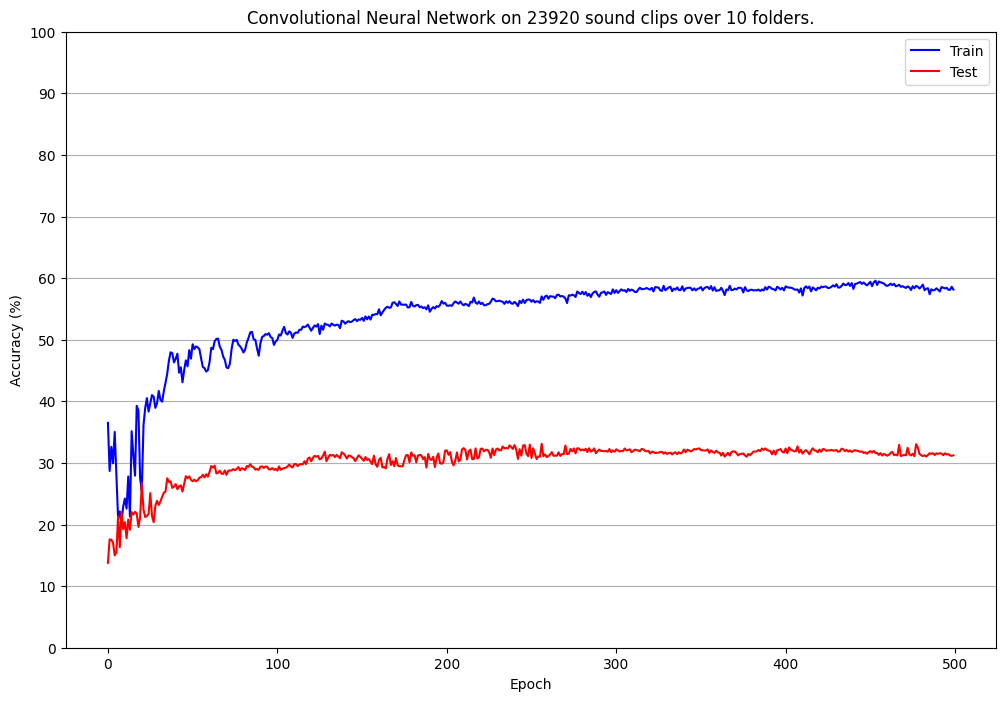

In [ ]:
# to avoid extreme overfitting:
# - dropout rate between 0.2-0.5 seems good
# - learning rate around 0.001 provides best training rate without overfitting
# - train in larger batches, 64 upwards seems good
# - most seem to plateau around 200 epochs, maybe reduce to reduce total training time

reset_seed()

epochs = 500
batch_size = 64
dropout_rate = 0
learning_rate = 0.001
momentum = 0

model = TestModel(input_shape=x_train.shape, dropout_rate=dropout_rate)
model = model.to(device)
loss_fn = nn.CrossEntropyLoss() # since we are classifying.
loss_fn = loss_fn.to(device)
optimizer = torch.optim.AdamW(params=model.parameters(), lr=learning_rate) # adam has no momentum, but DOES have weight decay

train_loss_hist, train_acc_hist, test_acc_hist, best_model = train_model(model, loss_fn, optimizer, epochs, batch_size, save_best_to_file=True)

In [ ]:
# final results after testing approx. 30 different variations of dropout, learning rate, etc
# best learning rate = 0.001, batch size of 32/64, dropout rate around 0.2-0.5
# 200 epochs gives best results as test acc plateaus after that, prevents overfitting
# train/test split between 20-30% gives good results

In [ ]:
# investigate TOP 5 ERROR of the model.
# compare with top 1 error (accuracy)

model.load_state_dict(best_model)
model.eval()

# get predictions for ALL testing data
k = 5
test_pred = model(x_test)
test_pred_top_k = torch.topk(test_pred, k=k, dim=1)[1]

total = 0
in_top_k = 0
for index, value in enumerate(y_test):
    if value in test_pred_top_k[index]: in_top_k += 1

    total += 1

top_k_accuracy = in_top_k * 100 / total

print(f"Top {k} Error: {top_k_accuracy:.03f}%")

Top 5 Error: 80.729%


In [ ]:
accuracy_df = pd.DataFrame(data=[y_test.cpu().numpy(), test_pred_top_k.cpu().numpy()], index=["actual", "pred"]).transpose()
accuracy_df["in_top_5"] = [1 if accuracy_df.iloc[i, 0] in accuracy_df.iloc[i, 1] else 0 for i in range(len(accuracy_df.index))]
folder_top_5 = accuracy_df.groupby(by="actual").aggregate(func=np.sum)["in_top_5"].values
folder_counts = accuracy_df.groupby(by="actual").aggregate(func=np.size)["in_top_5"].values
accuracy_df = pd.DataFrame(data=[folder_top_5, folder_counts], index=["in_top_5", "count"]).transpose()
accuracy_df["top_5_accuracy"] = round(accuracy_df["in_top_5"] * 100 / accuracy_df["count"], 2)
accuracy_df.sort_values(by="top_5_accuracy")

,in_top_5,count,top_5_accuracy
7,288,451,63.86
2,333,457,72.87
0,363,479,75.78
8,345,454,75.99
5,370,485,76.29
1,384,489,78.53
3,430,498,86.35
9,441,483,91.30
6,436,471,92.57
4,422,455,92.75


In [ ]:
# perform sequential aggregation.

test_frame = folder_df[folder_df["test"] == True]

seq_agg_preds = []

for i in range(len(test_frame)):
    row = test_frame.iloc[i]

    seq_agg_preds.append(torch.nn.Sigmoid()(model(row["mel_spec_data"].reshape(1, 1, row["mel_spec_shape"][0], row["mel_spec_shape"][1]).to(device)))[0].detach().cpu())

test_frame["pred"] = seq_agg_preds

rows = []

for file in test_frame["file"].unique():
    agg_list = test_frame[test_frame["file"] == file]["pred"].sum()

    row = [file, test_frame[test_frame["file"] == file]["folder_class"].unique()[0], agg_list, torch.argmax(agg_list).item()]

    rows.append(row)

test_frame_agg = pd.DataFrame(rows, columns=["file", "folder_class", "agg", "max"])
test_frame_agg["correct"] = test_frame_agg["max"] == test_frame_agg["folder_class"]
test_frame_agg

print(sum(test_frame_agg["correct"]) / len(test_frame_agg) * 100)